Dongmin Wu, 605308

$\pagebreak$

# b. Exercise on Regularisation

<p>A confounding problem in Machine Learning is how to construct a model that will perform well not just on the training data, but also on data that was not seen by the model during training. If the model fits the training data but does not have a good predicting performance/generalisation power we have an overfitting problem. Regularisation is a technique used to avoid the overfitting problem. Models that overfit data are complex models that have too many or too large magnitude parameters. The idea behind regularisation is to discourage complex models by penalising large magnitude or too many parameters with higher cost.</p>

<p>All methods that lead to improving the accuracy on the test set, possibly at the expense of increasing the training error, can be called as regularisation. To understand its effects and benefits, you will implement <b>L2 regularisation</b> in this exercise. This exercise is the second part of this week's exercises. The maximum points of this part is 2 points.</p>

<p>We will begin by first importing the necessary python libraries.</p>

In [1]:
import theano
import theano.tensor as T
from theano import pp
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

print('***** Import complete *****')

***** Import complete *****


<p>We are going to generate data for this exercise by ourselves. The dataset will consist only of points in a 2D-plane and the points belong to 3 different classes. For each class, there are 500 samples. In the following cell, we set the random seed for uniformity, make some intialisations for the data generation and generate the data. You can just run the cell to generate the data and do not really have to understand how it is generated.</p>

In [2]:
# Set the random seed
np.random.seed(234)

# Intialization of some parameters

# Number of input samples in each class
NX = 500 
# Dimension of the input samples, use 2 so that we can visualize
DX = 2
# Number of different classes
CL = 3 

# Template for the dataset

# Data features
X_data = np.zeros((NX * CL, DX))
# Class labels
y_data = np.zeros(NX * CL, dtype = 'uint8')

# Generation of spiral data
for j in range(CL):
    ix = range(NX*j,NX*(j+1))
    r = np.linspace(0.0,1,NX)
    t = np.linspace(j*4,(j+1)*4,NX) + np.random.randn(NX)*0.2
    X_data[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y_data[ix] = j

<p>It is a good practice to shuffle the data before we split it in to training set and test set.</p>

In [3]:
# Shuffle the data
m = X_data.shape[0]
# Shuffle the indices to the data
permutation = list(np.random.permutation(m))
X_data = X_data[permutation]
y_data = y_data[permutation]

<p>Now we can visualise the data. You will see three different classes forming three spiral-like forms. This kind of data can not be separated with linear classifiers.</p>

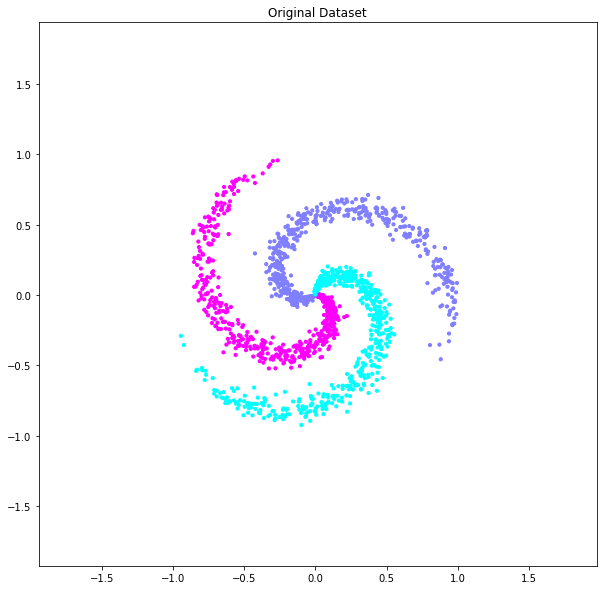

In [4]:
# Plot the input data and classes
hplot = 0.02
x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, hplot),
                     np.arange(y_min, y_max, hplot))
plt.figure(figsize=(10,10))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, s=10, cmap=plt.cm.cool)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Original Dataset')
plt.show()

<p>In order to make a more complex decision boundary for our assignment, we will add some noise into the data set.</p>

In [5]:
# Generate some Gaussian noise
input_noise = np.random.normal(loc=0., scale=0.2, size=[NX*CL, DX])
# Adding noise to the data
X_data = X_data + input_noise

<p>We intentionally use a small training set for this exercise so that we can practice how to avoid overfitting with regularisation. The effects of overfitting tend to be more pronounced when we have a small training dataset.</p>

In [6]:
# Create the training set
# Let us make a small training set, simulating a situation
# when we do not have a lot of training samples and thus a
# danger to overfit

# Training set dimensions: (200 x 2)
X = X_data[0:200]

# Training set labels dimensions: (200 x 1)
y = y_data[0:200]

<p>We will keep the test set relatively large so that we get reliable results for the test error.</p>

In [7]:
# Create the test set
# More data in the test set to get more reliable results

# Test set dimensions: (1300 x 2)
X_test = X_data[200:]

# Test set labels dimensions: (1300 x 1)
y_test = y_data[200:]

<p>Now we can plot the training set that has only 200 training samples. You can still see a spiral-like shape, but the data is rather noisy.</p>

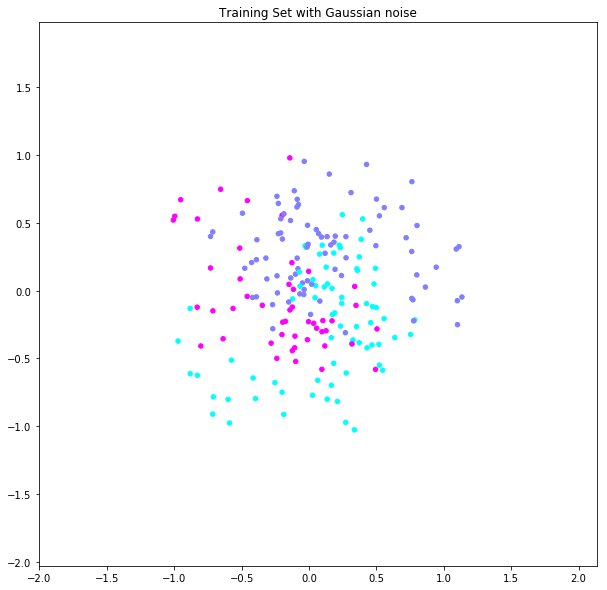

In [8]:
# Plot the training data and classes
hplot = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, hplot),
                     np.arange(y_min, y_max, hplot))
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.cool)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Training Set with Gaussian noise")
plt.show()

<p>And now we can also plot the noisy test data to see how it looks like.</p>

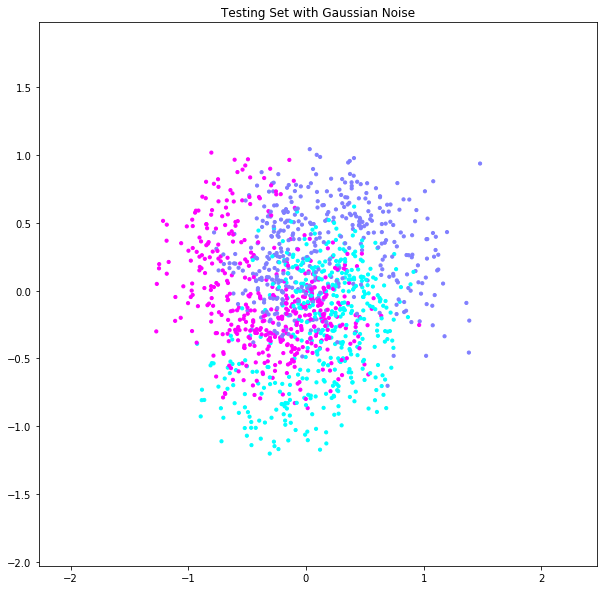

In [9]:
# Plot the test data and classes
hplot = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, hplot),
                     np.arange(y_min, y_max, hplot))
plt.figure(figsize=(10,10))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=10, cmap=plt.cm.cool)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Testing Set with Gaussian Noise')
plt.show()

<p>The idea of regularisation is to augment our loss function by adding a complexity term that would give a bigger loss for more complex models. Let $\theta_w$ represent the weights to be optimised excluding biases, $\mathcal{L}(\theta, \mathcal{D})$ be the cost function and $\lambda$ be the regularisation coefficient. We can write the L2 regularised cost function as follows:</p>

$$\mathcal{L}_{\lambda}(\theta, \mathcal{D}) = \mathcal{L}(\theta, \mathcal{D}) + \lambda \mid\mid\theta_w\mid\mid^{\mathbf{2}}_2$$ 

<p>Next, let us select some hyper-parameters. We will specify the regularisation coefficients that we are experimenting with in an array. If the regularisation coefficient is set 0.0, it means no regularisation is performed and hence, it will act as our baseline.</p>

In [10]:
# Regularisation coefficients
lambda_coef_arr = [0, 0.0003, 0.001, 0.0045]

# Set learning rate
learning_rate = 0.5

# Number of epochs in each iteration of the whole training set
training_steps = 15000

<p>We will construct a neural network with the following specifications:</p>
<ul>
<li>A fully connected Multi-Layer Perceptron network.</li>
<li>The MLP will have 2 hidden layers, each one will have 50 units.</li>
<li>Tanh activation function will be used.</li>
<li>L2 regularisation will be used.</li>
<li>Softmax added on the output layer for classification</li>
</ul>
<p>In the following cell, we will intialize the network weights and biases. This time we intialise all weights with a Gaussian of zero mean and 0.01 standard deviation and biases with 0.0. The network implemetation is going to be a 2-hidden layer MLP, with 50 neurons in each layer. We will initialise three weight matrices and three bias vectors.</p>

In [11]:
# Hidden layer dimensions
# Set number of neurons in the first hidden layer
hid1 = 50
# Set number of neurons in the second hidden layer
hid2 = 50

# Parameter initialisations
W_1 = theano.shared(np.random.normal(loc=0., scale=0.01, size=[DX, hid1]))
b_1 = theano.shared(np.zeros(hid1))
W_2 = theano.shared(np.random.normal(loc=0., scale=0.01, size=[hid1, hid2]))
b_2 = theano.shared(np.zeros(hid2))
W_o = theano.shared(np.random.normal(loc=0., scale=0.01, size=[hid2, CL]))
b_o = theano.shared(np.zeros(CL))

<p>We define the Theano variables for the input, target values and regularisation coefficients.</p>

In [12]:
# Theano inputs

# Input features
X1 = T.dmatrix()
# Class labels
target = T.ivector()
# Regularisation coefficent
lambda_coef = T.dscalar()

<p>In the following cell, we construct our Theano computational graph. We will calculate the first and second layer activations, predictions for the classifications, cost function, accuracy and gradients.</p>

In [13]:
# Theano computational graph

# Calculate the first and second hidden layer activations
a1 = T.dot(X1, W_1) + b_1
h1 = T.tanh(a1)
a2 = T.dot(h1, W_2) + b_2
h2 = T.tanh(a2)
a_out = T.dot(h2, W_o) + b_o

# Add softmax function to get the probabilities for each class.
y1 = T.nnet.softmax(a_out)

# Obtain prediction of correct class
y_pred = T.argmax(y1, axis = 1)

################# Insert Your Code Here ###################

# Implement L2 regularisation. Compute the L2 regularised cost 
# across all samples. Here, we shall use the categorical
# cross-entropy as the cost function.

# Compute the un-modified cost.
# Hint: Use T.nnet.categorical_crossentropy. Check the 
# Theano documentation for more information. Refer to the 
# previous demonstrations to see how the cost is computed.
cost_xent = T.nnet.categorical_crossentropy(y1, target).mean()

# Compute the L2 norm of all the weights that are to be 
# optimised. 
# Hint: We have 3 sets of weights W_1, W_2 and W_o. Refer to 
# chapter 7, section 7.1.1, page 227 in the Deep Learning 
# textbook. (online version, 21st Nov 2017)
L2_reg = lambda_coef  * (T.sum(W_1 ** 2) + T.sum(W_2 ** 2) + T.sum(W_o ** 2))

# Add the regularisation to the cost.
# Hint: Observe the formula for L2 regularised cost.
cost = cost_xent + L2_reg

##########################################################

# Calculate the accuracy by comparing the predictions to the labels
accuracy = T.mean(T.eq(y_pred,target))

# Calculate the gradients
gW_1 = T.grad(cost, W_1)
gb_1 = T.grad(cost, b_1)
gW_2 = T.grad(cost, W_2)
gb_2 = T.grad(cost, b_2)
gW_o = T.grad(cost, W_o)
gb_o = T.grad(cost, b_o)

<p>Let us define the training function that is called from the training loop later.</p>

In [14]:
# Training function and parameter updates
train = theano.function(
    inputs = [X1, target, lambda_coef],
    outputs = [y_pred, cost_xent],
    updates = [(W_1, W_1 - learning_rate * gW_1), 
               (b_1, b_1 - learning_rate * gb_1),
               (W_2, W_2 - learning_rate * gW_2), 
               (b_2, b_2 - learning_rate * gb_2),
               (W_o, W_o - learning_rate * gW_o), 
               (b_o, b_o - learning_rate * gb_o)]
                )

<p>Next, we define the Theano functions for predicting the correct class and for calculating the accuracy.</p>

In [15]:
# Theano function for predicting classes
pred_f = theano.function(inputs = [X1], 
                             outputs = y_pred)

# Theano function for accuracy evaluation
accuracy_f = theano.function(inputs = [X1, target], 
                             outputs = accuracy)


<p>In the next cell, we initialise some arrays to collect results for visualisation. You can skim through this.</p>

In [16]:
# Initialising some numpy arrays for collecting data for visualisations
points = int(training_steps/1000)
losses_all = np.empty((0, points))
accuracy_train_all = np.empty((0, points))
accuracy_test_all = np.empty((0, points))
train_acc_final = np.array([])
test_acc_final = np.array([])

# Create a training grid for the contour plot
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_train = np.c_[xx.ravel(), yy.ravel()]
Z_train = np.empty((0, grid_train.shape[0]))

# Create a testing grid for the contour plot
h = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_test = np.c_[xx.ravel(), yy.ravel()]
Z_test = np.empty((0, grid_test.shape[0]))

<p>Now we shall create the main training loop. The training loop is run for each regularisation coefficient in the array.</p>

In [17]:
for idx in range(len(lambda_coef_arr)):
    losses = np.array([])
    accuracy_train = np.array([])
    accuracy_test = np.array([])
    iteration = np.array([])
    lambda_coef = lambda_coef_arr[idx]
    print('***** Training model *****')
    
    for i in range(training_steps):
        # Call the previously defined training function.
        my_pred, my_cost = train(X, y, lambda_coef)
        if i % 1000 == 0:
            # Accumulate results for visualisation.
            losses = np.append(losses, my_cost)
            iteration = np.append(iteration, i)
            accuracy_train = np.append(accuracy_train, accuracy_f(X,y))
            accuracy_test = np.append(
                                      accuracy_test, 
                                      accuracy_f(X_test,y_test))
        if i % 5000 == 0:
            print("Iteration %d: loss %f" % (i, my_cost))
            print("Training accuracy", accuracy_f(X,y))
            print("Test accuracy", accuracy_f(X_test,y_test))
            
    # Accumulate the results
    losses = losses.reshape((1, points))
    losses_all = np.append(losses_all, losses, axis = 0)
    accuracy_train = accuracy_train.reshape((1, points))
    accuracy_train_all = np.append(accuracy_train_all, accuracy_train, axis=0)
    accuracy_test = accuracy_test.reshape((1, points))
    accuracy_test_all = np.append(accuracy_test_all, accuracy_test, axis=0)
    
    pred_train = pred_f(grid_train) 
    pred_train = pred_train.reshape((1, grid_train.shape[0]))
    Z_train = np.append(Z_train, pred_train, axis = 0)
    
    pred_test = pred_f(grid_test) 
    pred_test = pred_test.reshape((1, grid_test.shape[0]))
    Z_test = np.append(Z_test, pred_test, axis = 0)
    
    train_acc_final = np.append(train_acc_final, accuracy_f(X,y))
    test_acc_final = np.append(test_acc_final, accuracy_f(X_test,y_test))
    print('***** Training complete *****')
    
    # Re-initialise the weights and biases        
    W_1.set_value(np.random.normal(loc=0., scale=0.01, size =[DX, hid1]))
    b_1.set_value(np.zeros(hid1))
    W_2.set_value(np.random.normal(loc=0., scale=0.01, size =[hid1, hid2]))
    b_2.set_value(np.zeros(hid2))
    W_o.set_value(np.random.normal(loc=0., scale=0.01, size =[hid2, CL]))
    b_o.set_value(np.zeros(CL))

***** Training model *****
Iteration 0: loss 1.098611
('Training accuracy', array(0.405))
('Test accuracy', array(0.3223076923076923))
Iteration 5000: loss 0.347032
('Training accuracy', array(0.85))
('Test accuracy', array(0.6530769230769231))
Iteration 10000: loss 0.152264
('Training accuracy', array(0.925))
('Test accuracy', array(0.6346153846153846))
***** Training complete *****
***** Training model *****
Iteration 0: loss 1.098605
('Training accuracy', array(0.405))
('Test accuracy', array(0.3223076923076923))
Iteration 5000: loss 0.460782
('Training accuracy', array(0.81))
('Test accuracy', array(0.686923076923077))
Iteration 10000: loss 0.359803
('Training accuracy', array(0.835))
('Test accuracy', array(0.6592307692307692))
***** Training complete *****
***** Training model *****
Iteration 0: loss 1.098605
('Training accuracy', array(0.405))
('Test accuracy', array(0.3223076923076923))
Iteration 5000: loss 0.530787
('Training accuracy', array(0.78))
('Test accuracy', array(0.6

<p>Let's inspect the final training and test accuracies for each of the regularisation coefficients.</p>

In [18]:
for idx in range(len(lambda_coef_arr)):
    print("Regularisation coefficient: %f" %(lambda_coef_arr[idx]))
    print("Training Accuracy = %f%%" %(train_acc_final[idx] * 100.))
    print("Test Accuracy = %f%% \n" %(test_acc_final[idx] * 100.))

Regularisation coefficient: 0.000000
Training Accuracy = 100.000000%
Test Accuracy = 61.384615% 

Regularisation coefficient: 0.000300
Training Accuracy = 87.500000%
Test Accuracy = 65.230769% 

Regularisation coefficient: 0.001000
Training Accuracy = 80.000000%
Test Accuracy = 69.153846% 

Regularisation coefficient: 0.004500
Training Accuracy = 73.000000%
Test Accuracy = 66.153846% 



<p>We can also observe how the cost varies with different regularisation coefficients.</p>

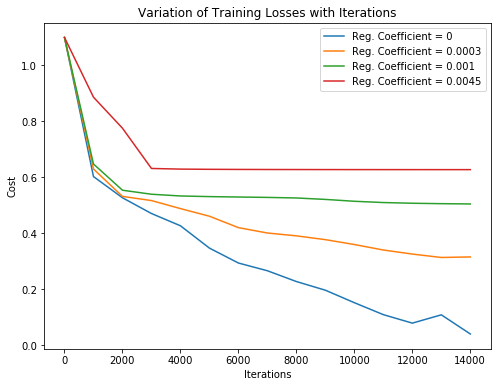

In [19]:
plt.figure(figsize=(8, 6))
for idx in range(len(lambda_coef_arr)):
    plt.plot(iteration, losses_all[idx, :],
             label='Reg. Coefficient = ' + str(lambda_coef_arr[idx]))
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Variation of Training Losses with Iterations')
plt.legend()
plt.show()

<p>Let's visualise how the classifier performs on the training data with a contour plot. Each colour corresponds to a class and depicts the prediction of our classifier. Observe the decision boundaries.</p>

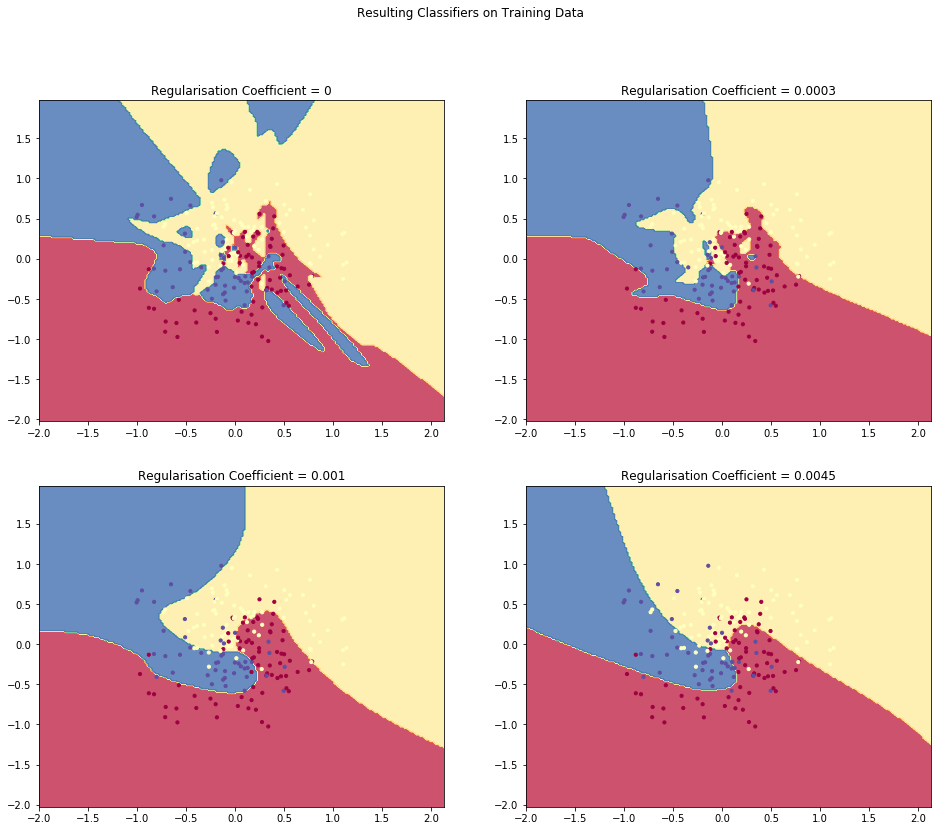

In [20]:
# Plot the resulting classifier and the training data
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
fig_tr, ax_tr = plt.subplots(2, 2, figsize=(16, 13))
fig_tr.suptitle(
    "Resulting Classifiers on Training Data")
for idx in range(len(lambda_coef_arr)):
    col = idx % 2
    row = int(idx / 2)
    Z = Z_train[idx, :]
    Z = Z.reshape(xx.shape)
    ax_tr[row][col].contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    ax_tr[row][col].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
    ax_tr[row][col].set_xlim(xx.min(), xx.max())
    ax_tr[row][col].set_ylim(yy.min(), yy.max())
    ax_tr[row][col].set_title(
        'Regularisation Coefficient = ' + str(lambda_coef_arr[idx]))
plt.show()

<p>We can also compare the performance of each of our classifiers with different regularisation parameters. Below, we plot the variations of both the training accuracies and test accuracies for each classifier.</p>

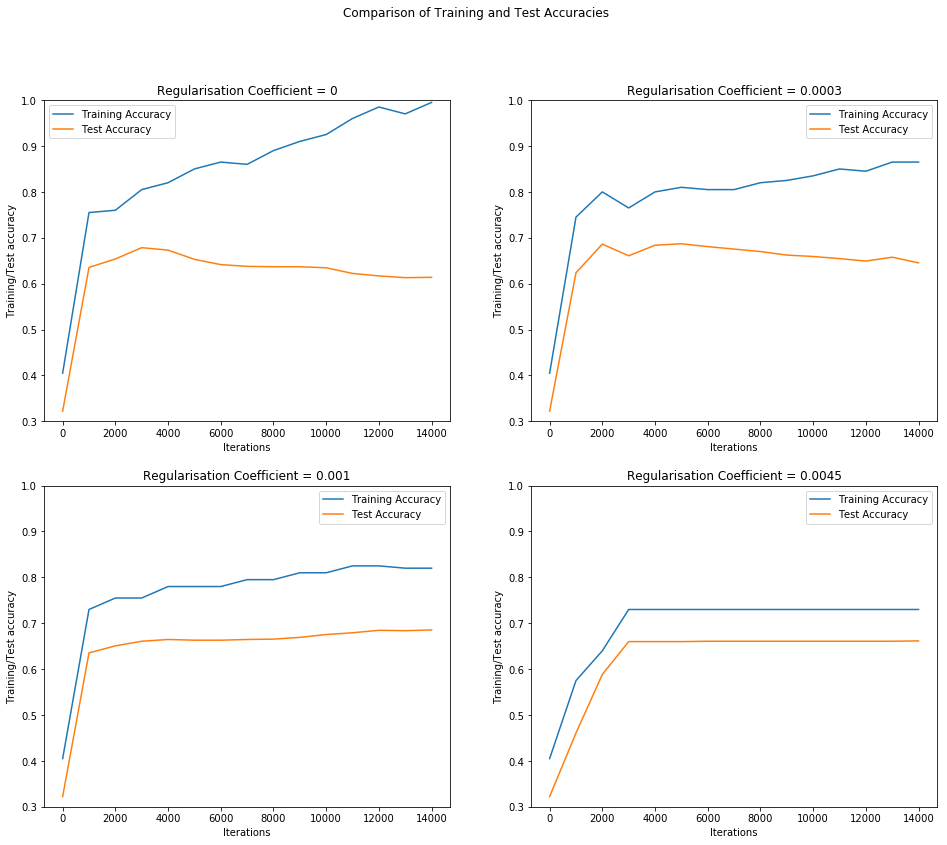

In [21]:
fig_acc, ax_acc = plt.subplots(2, 2, figsize=(16, 13))
fig_acc.suptitle(
    "Comparison of Training and Test Accuracies")
for idx in range(len(lambda_coef_arr)):
    col = idx % 2
    row = int(idx / 2)    
    ax_acc[row][col].plot(iteration, accuracy_train_all[idx, :],
                          label='Training Accuracy')
    ax_acc[row][col].plot(iteration, accuracy_test_all[idx, :],
                          label='Test Accuracy')
    ax_acc[row][col].set_ylim(0.3, 1)
    ax_acc[row][col].set_xlabel('Iterations')
    ax_acc[row][col].set_ylabel('Training/Test accuracy')
    ax_acc[row][col].set_title('Regularisation Coefficient = '
                               + str(lambda_coef_arr[idx]))
    ax_acc[row][col].legend()
plt.show()

<p>We can also visualise how the classifier performs on the testing data with a contour plot as before. Each colour corresponds to a class and depicts the prediction of our classifier. Observe these decision boundaries as well.</p>

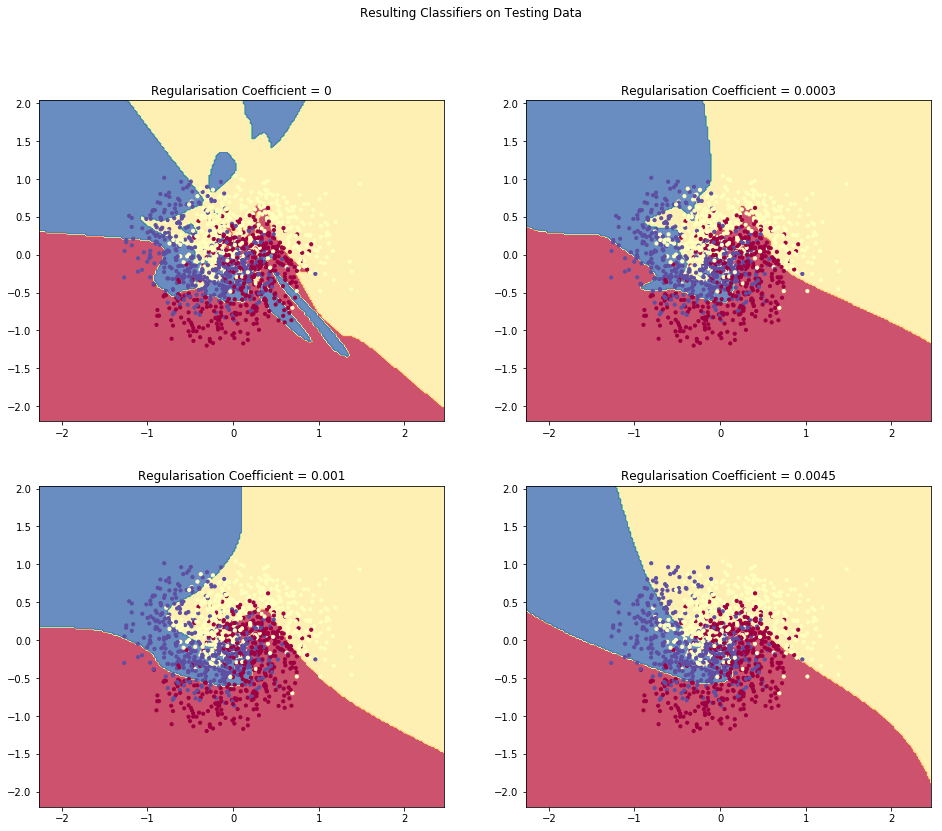

In [22]:
# plot the resulting classifier and the test data
h = 0.02
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
fig_test, ax_test = plt.subplots(2, 2, figsize=(16, 13))
fig_test.suptitle(
    "Resulting Classifiers on Testing Data")
for idx in range(len(lambda_coef_arr)):
    col = idx % 2
    row = int(idx / 2)
    Z = Z_test[idx, :]
    Z = Z.reshape(xx.shape)
    ax_test[row][col].contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    ax_test[row][col].scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                              s=10, cmap=plt.cm.Spectral)
    ax_test[row][col].set_xlim(xx.min(), xx.max())
    ax_test[row][col].set_ylim(yy.min(), yy.max())
    ax_test[row][col].set_title('Regularisation Coefficient = '
                                +str(lambda_coef_arr[idx]))
plt.show()

### Discussions

Replace this text with some key observations and discussion. What are your comments about the results? Do you have any observations on the cost and accuracy plot behaviour? What are your comments on the decision boundaries? What would be the appropriate regularisation parameter to choose?

Firstly, what we can find that the overlap among each class of data is considerably high, especially in the center of the "spin".

If we don't have any regularisation in the neural network, the model will try to match every point in the training data set, so the training cost is lowest. But the performance of test set is bad, the model overfitted the training data so much. Also, from the digram "comparison of Training and Test Accuracies", we are able to find the difference between this two accuracy is the largest too.

Along with the increase of the regularisation parameter, we find that the gap between test accuracy and training accuracy is converging. But the best accuracy in test set happends in `lambda_coef = 0.001` instead of `0.0045`, which means if the regulartion parameter is too large, it will also decrease the accuracy in the test set. It is a tipical underfitting issue.

About the boundaries, the smaller regularisation parameter lead to more fluctuate boundary and vice versa.

According to the result of this experiment, the best regularisation parameter will be `0.001`.


